# In this notebook we fit a SEIR model with hidden states to the Moscow Covid-19 data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
import lmfit
from tqdm.auto import tqdm

In [224]:
sns.set()
%matplotlib inline

In [225]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [226]:
%autoreload 2

In [227]:
from sir_models.models import SEIRHidden
from sir_models.fitters import HiddenCurveFitter
from sir_models.utils import stepwise, eval_k_days_ahead

# Load data

In [228]:
df = pd.read_csv('data/moscow_prepared.csv', parse_dates=['date'])
df = df.dropna()

In [229]:
df.head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7,infected_ma7
6,2020-03-18,86,1,0,0,31,0,85,44.43,0.57,0.0,0.0,12.29,0.14,43.86
7,2020-03-19,98,1,0,0,12,0,97,55.43,0.71,0.0,0.0,11.00,0.14,54.71
8,2020-03-20,131,5,0,0,33,4,126,70.43,1.43,0.0,0.0,15.00,0.71,69.00
9,2020-03-21,137,8,0,0,6,3,129,85.00,2.57,0.0,0.0,14.57,1.14,82.43
10,2020-03-22,191,8,0,0,54,0,183,107.29,3.57,0.0,0.0,22.29,1.00,103.71


# Model

In [230]:
train_subset = df[
    #(df.date >= '2020-03-25') &
    (df.date <= '2020-11-30')]

In [231]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

264   2020-12-01
265   2020-12-02
266   2020-12-03
Name: date, dtype: datetime64[ns]

In [232]:
train_subset.head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7,infected_ma7
6,2020-03-18,86,1,0,0,31,0,85,44.43,0.57,0.0,0.0,12.29,0.14,43.86
7,2020-03-19,98,1,0,0,12,0,97,55.43,0.71,0.0,0.0,11.00,0.14,54.71
8,2020-03-20,131,5,0,0,33,4,126,70.43,1.43,0.0,0.0,15.00,0.71,69.00
9,2020-03-21,137,8,0,0,6,3,129,85.00,2.57,0.0,0.0,14.57,1.14,82.43
10,2020-03-22,191,8,0,0,54,0,183,107.29,3.57,0.0,0.0,22.29,1.00,103.71


In [233]:
class SEIRHiddenMoscow(SEIRHidden):
    def get_fit_params(self, data):
        params = super().get_fit_params(data)
        params['epidemic_started_days_ago'].value = 20
        return params
    
class HiddenCurveFitterMoscow(HiddenCurveFitter):
    def __init__(self, *args,
                 new_recoveries_col='recovered_per_day',
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.new_recoveries_col = new_recoveries_col
        
    def residual(self, params, t_vals, data, model):
        model.params = params

        initial_conditions = model.get_initial_conditions(data)

        (S, E, I, Iv, R, Rv, D, Dv), history = model.predict(t_vals, initial_conditions, history=True)
        (new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)
        true_daily_cases = data[self.new_cases_col][:len(new_infected_visible)].values
        true_daily_deaths = data[self.new_deaths_col][:len(new_dead_visible)].values
        true_daily_recoveries = data[self.new_recoveries_col][:len(new_recovered_visible)].values


        resid_I_new = self.resid_transform(true_daily_cases, new_infected_visible)
        resid_D_new = self.resid_transform(true_daily_deaths, new_dead_visible)
        resid_R_new = self.resid_transform(true_daily_recoveries, new_recovered_visible)

        residuals = np.concatenate([
            resid_I_new,
            resid_D_new,
            resid_R_new,
        ]).flatten()
        return residuals


In [234]:
stepwize_size = 60
model = SEIRHiddenMoscow(stepwise_size=stepwize_size)
fitter = HiddenCurveFitterMoscow(
     new_deaths_col='deaths_per_day_ma7',
     new_cases_col='infected_per_day_ma7',
     new_recoveries_col='recovered_per_day_ma7',
#      brute_params=['epidemic_started_days_ago']
)
fitter.fit(model, train_subset)

In [235]:
result = fitter.result
result

In [236]:
incubation_days = model.params['incubation_days'].value
infectious_days = model.params['infectious_days'].value
print(f'Incubation period: {incubation_days:.2f}')
print(f'Infectious period: {infectious_days:.2f}')

Incubation period: 2.26
Infectious period: 9.13


In [237]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

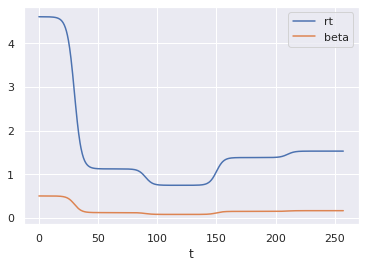

In [238]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.legend()
plt.show()

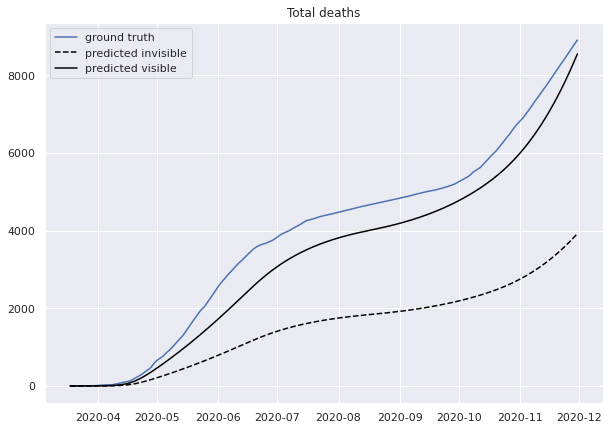

In [239]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
plt.show()

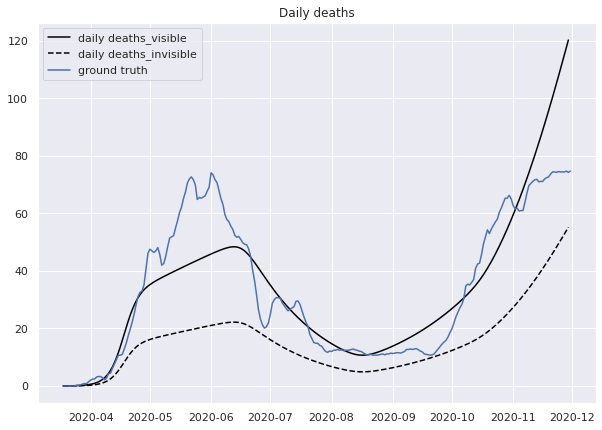

In [240]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')

plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')

plt.plot(train_subset.date, train_subset['deaths_per_day_ma7'], label='ground truth')
plt.legend()
plt.title('Daily deaths')
plt.show()

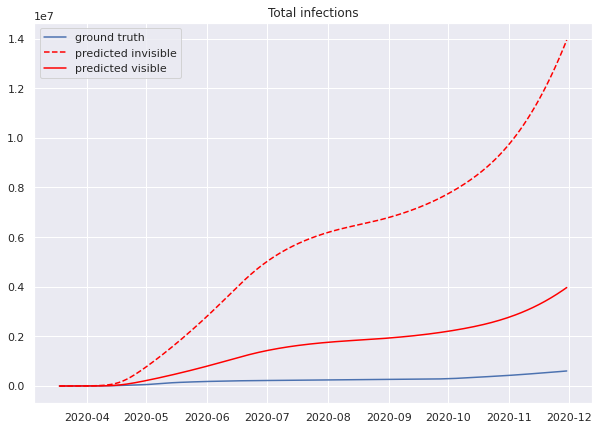

In [241]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_infected'], label='ground truth')
plt.plot(train_subset.date, I.cumsum(), label='predicted invisible', color='red', linestyle='dashed' )
plt.plot(train_subset.date, Iv.cumsum(), label='predicted visible', color='red')
plt.legend()
plt.title('Total infections')
plt.show()

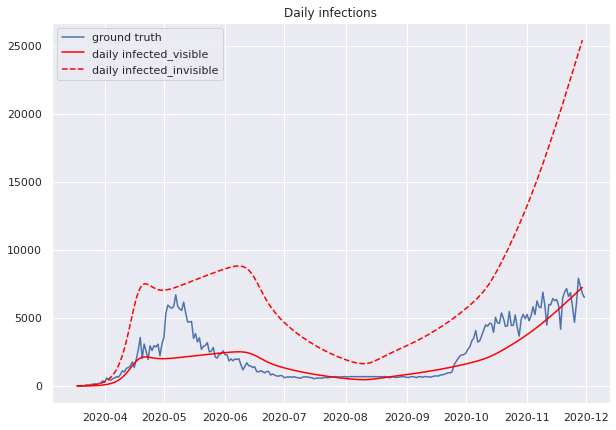

In [242]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'], label='ground truth')

plt.plot(train_subset.date[:-1], new_infected_visible, label='daily infected_visible', color='red')

plt.plot(train_subset.date[:-1], new_infected_invisible, label='daily infected_invisible', color='red', linestyle='dashed')
plt.legend()
plt.title('Daily infections')
plt.show()

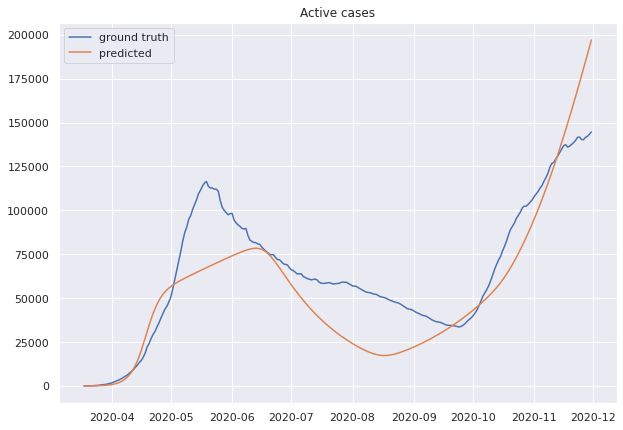

In [243]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='ground truth')
plt.plot(train_subset.date, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

# Obtain forecast

In [244]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [245]:
train_t, test_t

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [246]:
test_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])

In [247]:
(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv), history = model.predict(test_t, test_initial_conds)

In [248]:
(test_new_exposed,
         test_new_infected_invisible, test_new_infected_visible,
         test_new_recovered_invisible,
         test_new_recovered_visible,
         test_new_dead_invisible, test_new_dead_visible) = model.compute_daily_values(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv)

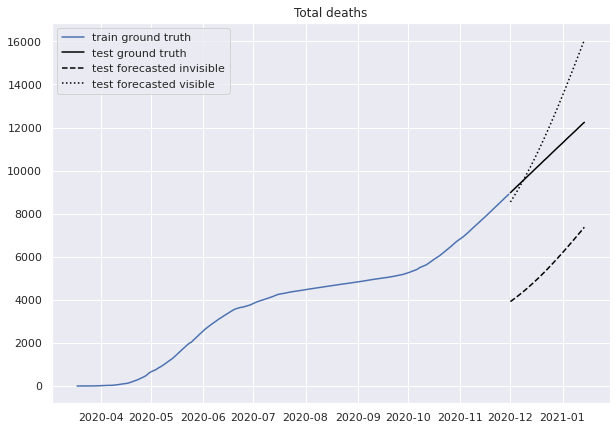

In [249]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
# plt.plot(train_subset.date, D, label='train fit invisible')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='black')
plt.plot(test_subset.date, test_D, label='test forecasted invisible', color='black', linestyle='dashed')
plt.plot(test_subset.date, test_Dv, label='test forecasted visible', color='black', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

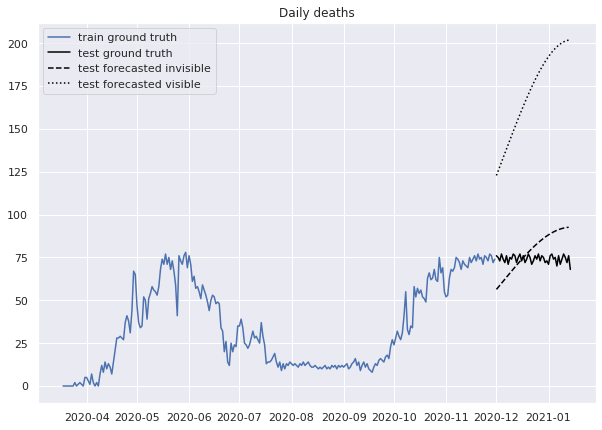

In [250]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['deaths_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['deaths_per_day'], label='test ground truth', color='black')
plt.plot(test_subset.date[:-1], test_new_dead_invisible, label='test forecasted invisible', color='black', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_dead_visible, label='test forecasted visible', color='black', linestyle=':')
plt.legend()
plt.title('Daily deaths')
plt.show()

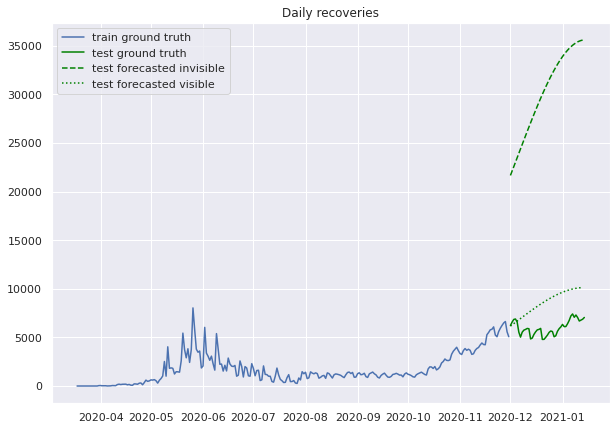

In [259]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['recovered_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['recovered_per_day'], label='test ground truth', color='green')
plt.plot(test_subset.date[:-1], test_new_recovered_invisible, label='test forecasted invisible', color='green', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_recovered_visible, label='test forecasted visible', color='green', linestyle=':')
plt.legend()
plt.title('Daily recoveries')
plt.show()

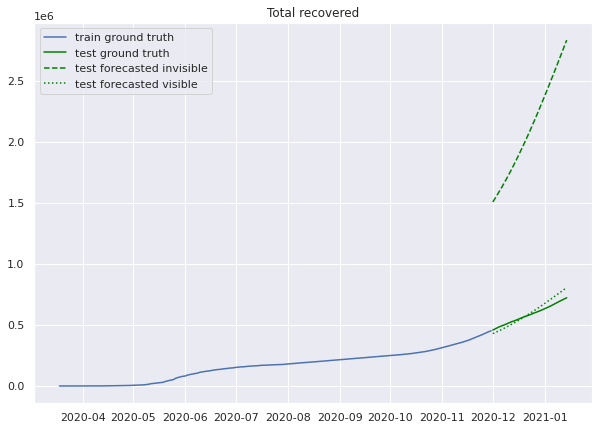

In [261]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='train ground truth')
plt.plot(test_subset.date, test_subset['total_recovered'], label='test ground truth', color='green')
plt.plot(test_subset.date, test_R, label='test forecasted invisible', color='green', linestyle='dashed')
plt.plot(test_subset.date, test_Rv, label='test forecasted visible', color='green', linestyle=':')
plt.legend()
plt.title('Total recovered')
plt.show()

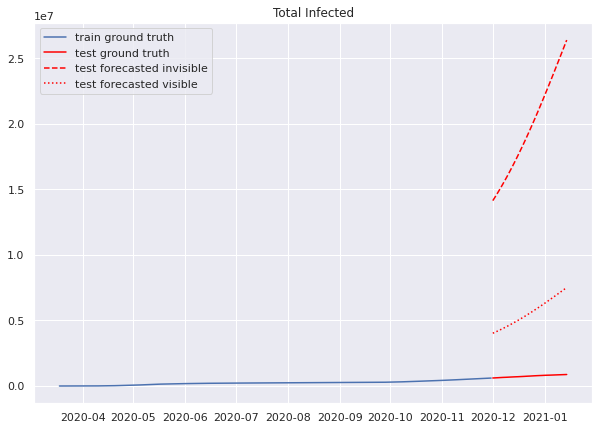

In [251]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_infected'], label='train ground truth')
# plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, test_subset['total_infected'], label='test ground truth', color='red')
plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date, Iv.sum()+test_Iv.cumsum(), label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Total Infected')
plt.show()

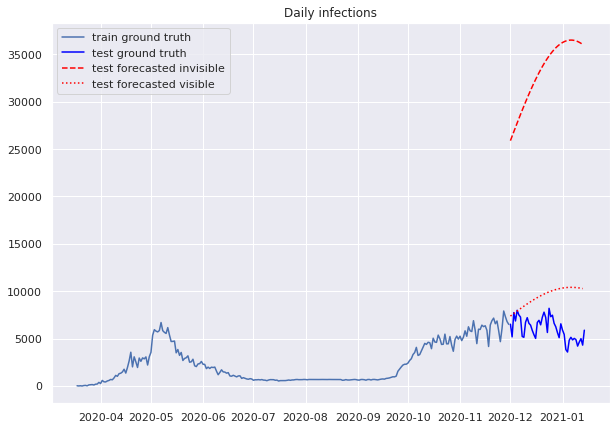

In [252]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'], label='train ground truth')

plt.plot(test_subset.date, test_subset['infected_per_day'], label='test ground truth', color='blue')
plt.plot(test_subset.date[:-1], test_new_infected_invisible, label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_infected_visible, label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Daily infections')
plt.show()

# 7-day ahead evaluate

In [253]:
# eval_one_day_ahead(df, SEIRHidden_OWID, HiddenCurveFitter, eval_period_start='2020-05-01', n_eval_points=10, total_dead_col='total_deaths', 
#                    model_kwargs={'stepwise_size': 60}, fitter_kwargs={'verbose': True}, deaths_index_in_compartments=7)

In [302]:
# Regions where Rt does not jump much
eval_dates1 = pd.date_range(start='2020-06-01', end='2020-09-01')[::5]
eval_dates2 = pd.date_range(start='2020-11-01', end='2021-01-01')[::5]
eval_dates = pd.concat([pd.Series(eval_dates1), pd.Series(eval_dates2)]).values
eval_dates[:10], len(eval_dates)

(array(['2020-06-01T00:00:00.000000000', '2020-06-06T00:00:00.000000000',
        '2020-06-11T00:00:00.000000000', '2020-06-16T00:00:00.000000000',
        '2020-06-21T00:00:00.000000000', '2020-06-26T00:00:00.000000000',
        '2020-07-01T00:00:00.000000000', '2020-07-06T00:00:00.000000000',
        '2020-07-11T00:00:00.000000000', '2020-07-16T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 32)

In [303]:
def eval_k_days_ahead_dates(df, 
                      model_cls,
                      fitter_cls,
                      eval_dates,
                      total_dead_col='total_deaths',
                      model_kwargs=None,
                      fitter_kwargs=None,
                      deaths_index_in_compartments=4,
                      k=7):
    model_kwargs = model_kwargs or {}
    fitter_kwargs = fitter_kwargs or {'verbose': False}

    pred_dates = []
    true_D = []
    baseline_pred_D = []
    model_pred_D = []
    fitters = []

    progress_bar = tqdm(eval_dates, total=len(eval_dates))
    for date in progress_bar:
        t = len(df[df.date < date])
        train_df = df.iloc[:t]

        model = model_cls(**model_kwargs)
        fitter = fitter_cls(**fitter_kwargs)
        fitter.fit(model, train_df)

        train_initial_conditions = model.get_initial_conditions(train_df)
        train_t = np.arange(len(train_df))
        state, history = model.predict(train_t, train_initial_conditions)

        test_initial_conds = [compartment[-1] for compartment in state]
        eval_t = np.arange(train_t[-1]+1, t+k, 1)

        state, history = model.predict(eval_t, test_initial_conds)

        D = state[deaths_index_in_compartments]

        pred_dates.append(df.date.iloc[t:t+k].values)
        model_pred_D.append(D)
        baseline_pred_D.append([train_df.iloc[-1][total_dead_col]] * k)
        true_D.append(df[total_dead_col].iloc[eval_t].values)
        fitters.append(fitter)

    return pred_dates, baseline_pred_D, model_pred_D, true_D, fitters


In [ ]:
pred_dates, baseline_pred_D, model_pred_D, true_D = eval_k_days_ahead_dates(df, 
                  SEIRHiddenMoscow, 
                  HiddenCurveFitterMoscow, 
                  eval_dates=eval_dates, 
                  total_dead_col='total_dead', 
                  model_kwargs={'stepwise_size': 60}, 
                  fitter_kwargs=dict(verbose=True,
                                     new_deaths_col='deaths_per_day_ma7',
                                     new_cases_col='infected_per_day_ma7',
                                     #brute_params=['epidemic_started_days_ago']
                                    ), 
                  deaths_index_in_compartments=7,
                  k=30)

In [299]:
# eval_period_start_t = len(df[df.date < '2020-05-01'])

In [300]:
# pred_dates, baseline_pred_D, model_pred_D, true_D = eval_k_days_ahead(df, 
#                   SEIRHiddenMoscow, 
#                   HiddenCurveFitterMoscow, 
#                   eval_period_start=eval_period_start_t, 
#                   n_eval_points=10, 
#                   total_dead_col='total_dead', 
#                   model_kwargs={'stepwise_size': 60}, 
#                   fitter_kwargs=dict(verbose=True,
#                                      new_deaths_col='deaths_per_day_ma7',
#                                      new_cases_col='infected_per_day_ma7',
#                                      #brute_params=['epidemic_started_days_ago']
#                                     ), 
#                   deaths_index_in_compartments=7,
#                   k=7)

In [ ]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]

point_errors_model = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, model_pred_D)]
point_errors_baseline = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, baseline_pred_D)]

In [ ]:
print('Mean overall error baseline', np.mean(overall_errors_baseline))
print('Mean overall error model', np.mean(overall_errors_model))

print('Mean point 7 days ahead error baseline', np.mean(point_errors_baseline))
print('Mean point 7 days ahead error model', np.mean(point_errors_model))

In [ ]:
x_dates = [d[-1] for d in pred_dates]

plt.figure(figsize=(10, 7))
plt.plot(x_dates, overall_errors_model, label='Model overall errors')
plt.plot(x_dates, overall_errors_baseline, label='Baseline overall errors')

plt.plot(x_dates, point_errors_model, label='Model point errors')
plt.plot(x_dates, point_errors_baseline, label='Baseline point errors')

plt.legend()
plt.ylabel('Mean absolute error')
plt.title('Model performance grows compared to baseline as more data is added')
plt.show()

In [ ]:
x_dates = [d[-1] for d in pred_dates]

plt.figure(figsize=(10, 7))
plt.scatter(x_dates, [v[-1] for v in true_D], label='True dead')
plt.scatter(x_dates, [v[-1] for v in baseline_pred_D], label='Baseline pred dead')
plt.scatter(x_dates, [v[-1] for v in model_pred_D], label='Model pred dead')

plt.legend()
plt.show()